In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geocoder
from time import sleep

In [11]:
from scipy.optimize import fmin, fmin_bfgs

In [2]:
import seaborn as sns
sns.set(style="ticks", palette="Set2")

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
cd

/Users/mmngreco


In [4]:
pwd

'/Users/mmngreco'

In [5]:
%matplotlib inline

# PROBLEMA 

## $\min_{x_0, y_0}{\sum{c_i · w_i · d_i}}$

## $d_i = \sqrt{(x_i - x_0)^2 + (y_i - x_0)^2}$

__DONDE:__

- $c_i$: Coste ¿unitario?.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años)
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud)
- $y_i$: Coordenada eje y (Latitud)

__Variables de decisión:__ $x_0, y_0$ 

In [13]:
def func_obj(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    return sum(wi * ci * di(xy0))
    

# SIMULACIÓN

## DEMANDA (CLIENTES)

### SERIE TEMPORAL TIPO:

### $y_t = \delta_0 + \delta_1 · t + u_t$

### Donde:
- $y_t$ : Ventas para cada período t.
- $\delta_0$ : Ventas indendientes o autónomas. (Stock de Seguridad pe.)
- $\delta_1$ : Pendiente la recta.
- $u_t$ : Ruido ~ N(0, 5)

En este caso para darle más realismo, $\delta_0 = \delta_a + \delta_b · sin(x)$, de esta forma introducimos un posible componente estacional, que depende cuán grande sea $\delta_b$.

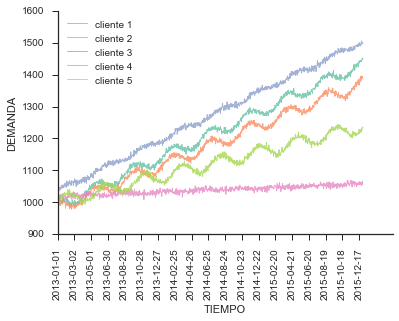

In [95]:
clientes = dict()
days_by_year = 365
nperiodos = 3 * days_by_year
tiempo = np.linspace(0 , 50, nperiodos)

for c in range(5):

    pendiente = np.random.uniform(0.5, 10)
    ruido = np.random.normal(0, 5, nperiodos)
    freq = np.random.normal(10, 10)
    demanda_a = np.random.normal(1000, 30)
    band = np.random.uniform() < 0.4
    demanda = demanda_a + (np.cos(tiempo)*band + np.sin(tiempo)*(1-band)) * freq + pendiente * tiempo + ruido
    cname = 'cliente %s' % (c+1)
    clientes[cname] = demanda

    plt.plot(demanda, alpha=0.8, label=cname, linewidth=0.91)

sns.despine()
plt.legend(loc=2)
tlabel = pd.date_range(end='2015-12-31', periods=nperiodos, freq='D')
plt.xlabel('TIEMPO')
plt.xticks(range(0, len(tiempo), 60), [t.date() for t in tlabel[0::60]], rotation=90)
plt.ylabel('DEMANDA')

In [20]:
xys = pd.read_csv('Documents/repos/unizar/SIAD/Trabajo Grupo/clientes_xys.csv')

In [24]:
yi = xys.lat.values
xi = xys.lng.values

In [96]:
list(xi)

[-2.9349852000000003,
 -0.4078058,
 -3.7037902000000003,
 -5.8493887000000004,
 -0.88908530000000008]

## COSTES

$c_i$: Es el coste por unidad de producto vendida.

Suponemos que esta empresa ya maximiza beneficios y los precios son exógenos. Por tanto la oferta igual a la demanda, siendo ésta última estimada como la media de los últimos 3 años.

$w_i$ = $E(w_i|T)$

In [50]:
wi = np.array([np.mean(v) for v in clientes.values()])
ci = np.random.uniform(1, 100) + 1
di = lambda xy0: np.sqrt((xi-xy0[0]) ** 2 + (yi-xy0[1]) ** 2)

In [51]:
for i, w in enumerate(wi):
    print('w%s =' % (i + 1), w)
print('ci =', ci)

w1 = 1086.4589801
w2 = 1052.83801576
w3 = 1042.11401932
w4 = 1135.56408025
w5 = 1231.49203172
ci = 78.0040773770677


# OPTIMIZACIÓN

In [52]:
res = fmin(func_obj, [0,0])

Optimization terminated successfully.
         Current function value: 920996.700820
         Iterations: 99
         Function evaluations: 192


In [53]:
res

array([ -2.38003786,  42.21274007])

In [45]:
res

array([ -2.38006728,  42.21272044])

In [45]:
res

array([ -2.38006728,  42.21272044])

# RESULTADO

Con los datos simulados, la solución óptima para el problema planteado es [ 42.23885306,  -2.5716388 ], y la función toma el valor 934296.653775.

In [54]:
file_name = 'Documents/repos/unizar/SIAD/Trabajo Grupo/xys_backup.csv'
file_clientes = 'Documents/repos/unizar/SIAD/Trabajo Grupo/clientes_xys.csv'

In [105]:
xys = pd.read_csv(file_name)
xys.drop_duplicates(inplace=True)
clientes_xys = pd.read_csv(file_clientes)

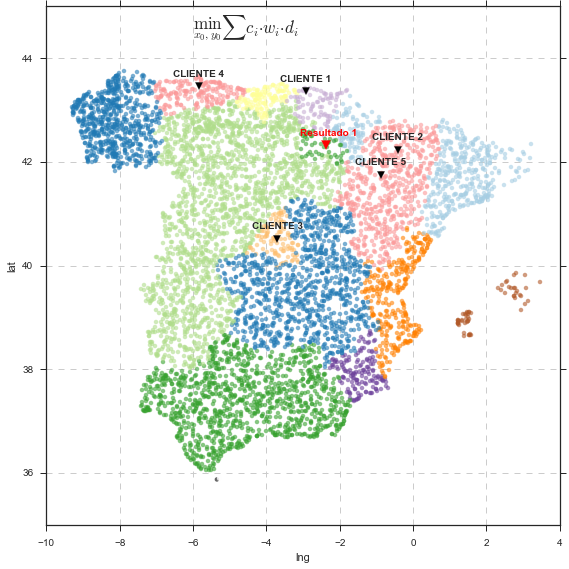

In [108]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# TERRITORIO
for i, region in enumerate(xys[xys.pais == 'ES'].prov.unique()):
    i = n_color[i]
    xys[xys.prov == region].plot(kind='scatter', 
                                 x='lng', 
                                 y='lat', 
                                 alpha=0.6, 
                                 ax=ax, 
                                 color=color[i], 
                                 marker='o',
                                 linewidths=0)
# CLIENTES
for i, (y, x) in enumerate(zip(clientes_xys.lat.values, clientes_xys.lng.values)):

    plt.scatter(x, y*1.0025, color='black', marker='v', s=50)
    plt.text(x - 0.7,
             y + 0.3,
             'CLIENTE %s' % (i+1), weight='bold')

# RESULTADO
plt.scatter(res[0], res[1]*1.0025, color='red', marker='v', s=80)
plt.text(res[0] - 0.7, 
         res[1] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='red')


plt.text(-6, 44.5, '$\min_{x_0,y_0}{\sum{c_i·w_i·d_i}}$', weight='bold', fontsize=17)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')
plt.tight_layout()


> __NOTA:__ 
En los mapas físicos, las coordenadas están expresadas en grados, por ejemplo Puerto Rico sería: 18°14’70” N  66°29’68” W
Para convertir:
- $(18°14'70" N) = (18 + (14 / 60) + (70 / 3600)) = 18.252$
- $(66°29'68" W) = -(66 + (29 / 60) + (68 / 3600)) = -66.8627$

> La longitud se multiplica por __negativo__, porque está a la __izquierda (oeste)__ del punto 0,0.

# RESTRICCIÓN ADICIONAL

Al problema anterior, le agregamos una restricción adicional de tipo geográfica. Cada comunidad autónoma pasará a cobrar un impuesto por unidad vendida, el tipo impositivo dependerá de la comunidad autónoma, de forma que es probable que la elección óptima cambie.

Es decir:

# PROBLEMA INICIAL + RESTRICCIÓN

## $\min_{x_0, y_0}{\sum{c_i(1+t_i) · w_i · d_i}}$

__DONDE:__

- $c_i$: Coste unitario.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años).
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud).
- $y_i$: Coordenada eje y (Latitud).
- __$t_i$: Impuesto por unidad vendida.__

__Variables de decisión (Coordenadas):__ $x_0, y_0$ 


In [72]:
ti = np.random.uniform(size=17)

In [73]:
for i,t in enumerate(ti):
    print('t%s' % (i+1), t)

t1 0.320351947193
t2 0.96682683666
t3 0.572543091313
t4 0.577979758781
t5 0.692278099662
t6 0.172057087255
t7 0.100097567443
t8 0.147094942877
t9 0.247888854899
t10 0.597454875036
t11 0.803867819754
t12 0.207054059808
t13 0.332077780051
t14 0.403454157479
t15 0.419630353657
t16 0.0906537545431
t17 0.435834276552


In [74]:
for i, ca in enumerate(xys[xys['pais'] == 'ES'].prov.unique()):
    print(i, ca, ti[i])

0 Región de Murcia 0.320351947193
1 Comunidad Valenciana 0.96682683666
2 AL 0.572543091313
3 CL 0.577979758781
4 Navarra 0.692278099662
5 Principado de Asturias 0.172057087255
6 Cantabria 0.100097567443
7 GA 0.147094942877
8 Comunidad de Madrid 0.247888854899
9 PV 0.597454875036
10 PM 0.803867819754
11 CM 0.207054059808
12 CT 0.332077780051
13 EX 0.403454157479
14 La Rioja 0.419630353657
15 Aragón 0.0906537545431
16 CE 0.435834276552


# EN R 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R -o data data <- readRDS("Downloads/ESP_adm1-2.rds")

In [ ]:
%%R
plot(data[1])

# Google Maps

![](http://www.elandroidelibre.com/wp-content/uploads/2015/06/google-maps-logo.jpg)

In [75]:
# PRUEBA 
# COORDENADAS DE LAS LOCALIDADES

localidades = ['zaragoza', 
               'oviedo', 
               'huesca', 
               'madrid', 
               'bilbao']

coords = dict()

for loc in localidades:

    g = geocoder.google(loc)
    
    print('city', g.json['city'])
    print('state', g.json['state'])
    print('address', g.json['address'])
    print('county', g.json['county'])

    lat = g.json['lat']
    lng = g.json['lng']

    print(loc, lat, lng)
    print('\n––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––\n')
    coords[loc] = [lat, lng]


city Zaragoza
state Aragon
address Zaragoza, Zaragoza, Spain
county Z
zaragoza 41.6488226 -0.8890853 41.6583112552

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

city Oviedo
state Principado de Asturias
address Oviedo, Asturias, Spain
county O
oviedo 43.3619145 -5.8493887 43.7546680626

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

city Huesca
state Aragon
address Huesca, Huesca, Spain
county Huesca
huesca 42.131845 -0.4078058 42.1338185864

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

city Madrid
state Community of Madrid
address Madrid, Madrid, Spain
county M
madrid 40.4167754 -3.7037902 40.5861281176

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

city Bilbao
state PV
address Bilbao, Biscay, Spain
county BI
bilbao 43.2630126 -2.9349852 43.3624537746

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––



# MUESTREO ALEATORIO SIMPLE 
---


In [123]:
%%HTML
<iframe src="https://mapsengine.google.com/map/embed?mid=zTtXepJtMlLc.k6VXMPFTI7DI" width="740" height="480"></iframe>

In [121]:
# montecarlo
nobs = np.sqrt(2000)
xmin, xmax = -9.29769, 3.29314
ymax = 43.77702
ymin = 36.01356

xs = np.repeat(np.linspace(xmin, xmax, nobs), nobs)
ys = list(np.linspace(ymin, ymax, nobs)) * nobs
ys = np.array(ys).flatten()

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


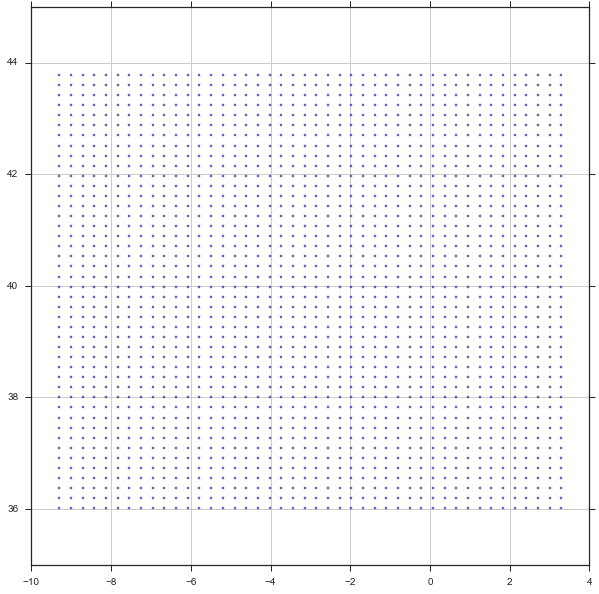

In [126]:
plt.figure(figsize=(10,10))
plt.scatter(xs, ys, marker='.', alpha=0.6)
plt.gca().grid(True)

# MONTECARLO

## INFORMACIÓN

In [118]:
g = geocoder.google([41.6894079, -0.8427317], method='reverse')

In [119]:
g.json

{'accuracy': 'ROOFTOP',
 'address': 'Diseminado S Gregorio el Cascajo, 9124, 50059 Zaragoza, Zaragoza, Spain',
 'bbox': {'northeast': [41.6924489802915, -0.842331019708498],
  'southwest': [41.6897510197085, -0.8450289802915021]},
 'city': 'Zaragoza',
 'confidence': 9,
 'country': 'ES',
 'county': 'Z',
 'encoding': 'utf-8',
 'housenumber': '9124',
 'lat': 41.6911,
 'lng': -0.84368,
 'location': '41.6894079, -0.8427317',
 'ok': True,
 'postal': '50059',
 'provider': 'google',
 'quality': 'street_address',
 'state': 'Aragón',
 'status': 'OK',
 'status_code': 200,
 'street': 'Diseminado S Gregorio el Cascajo'}

In [120]:
g.json['county']

'Z'

# MUESTREO

In [125]:
# googlemaps
# from collections import defaultdict
# montecarlo = defaultdict(lambda : defaultdict(lambda : defaultdict(tuple)))
montecarlo = dict()
n=0

for x in zip(ys,xs):
    g = geocoder.google(x, method='reverse')
    n += 1
    
    print(n, end=' ')

    try:
        loc = '%s: %s: %s' % (g.json['country'], g.json['state'], g.json['county'])

    except:
        continue

    lat = g.json['lat']
    lng = g.json['lng']
#    xy = [lat, lng]
    xy = [list(x)]
    montecarlo[loc] = montecarlo.get(loc, xy) + xy


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

# MAPA DEL MUESTREO

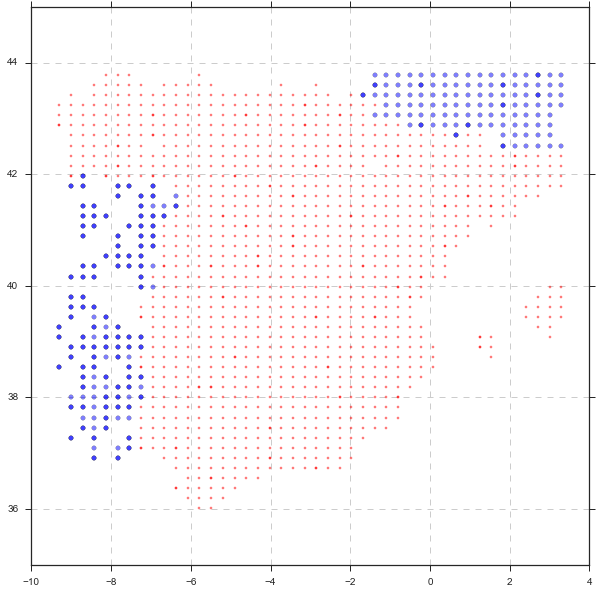

In [131]:
plt.figure(figsize=(10,10))
for k, cs in montecarlo.items():
    x = [c[0] for c in cs]
    y = [c[1] for c in cs]

    if k.startswith('ES'):
        plt.scatter(y, x, color='red', marker='.', alpha=0.5)
    else:
        plt.scatter(y, x, alpha=0.5)
plt.gca().grid(True, linestyle='--')
#plt.ylim(ymin, ymax)
#plt.xlim(xmin, xmax)

# ALTERNATIVA

In [ ]:
mapquest_api = open('Documents/mq_api.txt').read()
gmaps_api = open('Documents/googlemaps_api.txt').read()
geocoder_api = open('Documents/geocoder_api.txt').read()
mbox_api = open('Documents/mbox_api.txt').read()

# EXPORTAR DATOS

In [134]:
fname = 'Documents/repos/unizar/SIAD/Trabajo Grupo/xys_pais_ca_prov_rejilla.csv'
f = open(fname, 'a')
for key, xys in montecarlo.items():
    for xy in xys:
        print('%s,%s,%s,%s,%s' % (*key.split(': '), *xy), file=f)

f.close()

# EXPORTAR DATOS

In [28]:
# formato antiguo
f = open(file_name, 'a')
for name, xys in montecarlo.items():
    for xy in xys:
        print('%s,%s,%s' % (name, *xy), file=f)
f.close()

# IMPORTAR DATOS

In [137]:
xys = pd.read_csv(fname, header=None)

In [138]:
xys.head()

,0,1,2,3,4
0,PT,Setúbal,Grândola,38.180107,-8.71207
1,PT,Setúbal,Grândola,38.180107,-8.71207
2,PT,Setúbal,Grândola,38.180107,-8.41926
3,PT,Faro,Silves,37.277379,-8.41926
4,PT,Faro,Silves,37.277379,-8.41926


In [139]:
xys.columns = ['pais', 'ca', 'prov', 'lat', 'lng']

In [143]:
xys[xys.pais == 'ES'].prov.unique()

array(['Lugo', 'Cáceres', 'M', 'León', 'VA', 'Palencia', 'T',
       'Illes Balears', 'Jaén', 'LO', 'Cdad. Real', 'A', nan, 'O', 'Ávila',
       'Araba', 'Badajoz', 'TO', 'SS', 'Castelló', 'Islas Baleares', 'BI',
       'AL', 'Ourense', 'C', 'B', 'S', 'Castellón', 'Sevilla', 'Girona',
       'Zamora', 'Lérida', 'Málaga', 'Gerona', 'Soria', 'Cuenca',
       'Guadalajara', 'Huesca', 'CA', 'Córdoba', 'Lleida', 'SA', 'Teruel',
       'MU', 'Z', 'V', 'PO', 'Huelva', 'Albacete', 'Burgos', 'Orense',
       'Granada', 'SG'], dtype=object)

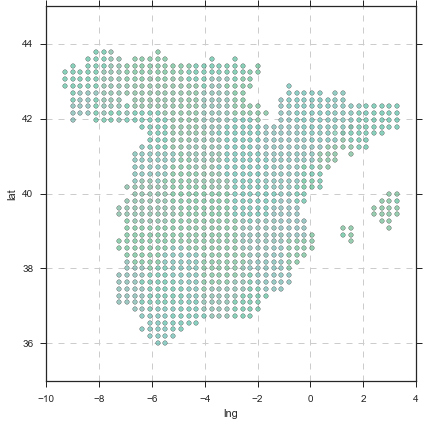

In [151]:
plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)

xys.dropna(inplace=True)
xys.drop_duplicates(inplace=True)

xys[xys.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', alpha=0.7, ax=ax)

color = sns.color_palette("Set1", 17)
color = sns.color_palette("husl", len(xys[xys.pais == 'ES'].prov.unique()))
#color = sns.color_palette("cubehelix", 17)


#n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

for i, region in enumerate(xys[xys.pais == 'ES'].prov.unique()):
#    i = n_color[i]
    xys[xys.prov == region].plot(kind='scatter', 
                                 x='lng', 
                                 y='lat', 
                                 alpha=0.1, 
                                 ax=ax, 
                                 color=color[i], 
                                 marker='o')

plt.xlim(-10,4)
ax.grid(True, linestyle='--')
plt.tight_layout()

In [65]:
xys.to_csv('Documents/repos/unizar/SIAD/Trabajo Grupo/xys_backup.csv', index=False)

In [157]:
url = 'https://en.wikipedia.org/wiki/ISO_3166-2:ES'

# obtener códigos ISO:
ca_iso, prov_iso = pd.read_html(url, header=0, encoding='Latin')[:2]

prov_iso.columns = 'codigo nombre ca'.split()
ca_iso.drop(ca_iso.columns[-1], axis=1, inplace=True)
ca_iso.columns = 'codigo ca'.split()